In [65]:
import numpy as np
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 6,6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

V1481A = np.array([24.36, -17.04, 13.26, 59.44, 45.43, -8.61, -9.37, 20.98, 63.91, -2.29, 55.55])
Aerror = np.array([1.25, 1.04, 1.03, 1.03, 1.02, 1.17, 1.04, 1.25, 1.09, 1.10, 1.14])
V1481B = np.array([96.34, 45.27, -43.73, -24.96, 78.60, 82.46, -50.16, 70.06, -37.94])
Berror = np.array([0.83, 0.82, 0.82, 0.81, 0.94, 0.83, 0.88, 0.88, 0.91])
JD     = np.array([2453658.8320, 2453659.8226, 2453660.8243, 2453661.8003, 2453662.8240, 2453663.8200,
                   2453664.7964, 2453678.7838, 2453679.7282, 2453753.6614, 2453755.6823])
JDB    = np.array([2453659.8226, 2453660.8243, 2453661.8003, 2453662.8240, 2453663.8200,
                   2453664.7964, 2453679.7282, 2453753.6614, 2453755.6823])

DQTau1 = np.array([34.76, -2.93, 37.11, 37.38, 34.73, 31.64, 26.07, 23.51, 20.10, 17.31, 27.28, 36.99, 33.17,
                   35.11, 35.24, 28.81, 12.43, 40.09, 35.14, 35.89, 19.12, 37.08, 36.83, 12.75, -6.27, 14.82,
                   34.84,  3.16, 32.37, 39.09, 17.46, 22.67, 31.34])
oneError = np.array([3.93, 3.61, 7.72, 3.56, 3.35, 3.23, 4.56, 5.11, 4.96, 4.46, 3.19, 5.66, 5.28, 3.15, 6.15,
                     2.92, 3.01, 2.92, 3.12, 3.31, 3.35, 3.27, 3.41, 3.41, 4.17, 4.56, 4.56, 3.08, 3.08, 4.82,
                     3.95, 3.95, 3.95])
DQTau2 = np.array([12.44, 56.13, 13.90, 15.01, 17.06, 20.70, 24.40, 27.30, 25.73, 27.86, 23.67, 7.64, 10.94,
                   09.87, 10.05, 19.93, 33.26, 13.83, 11.47, 16.98, 26.86, 10.20, 14.36, 23.86, 50.94, 37.61,
                   07.51, 52.75, 17.20, 08.27, 34.61, 26.25, 11.49])
twoError = np.array([2.53, 2.32, 4.97, 2.29, 2.16, 2.08, 2.94, 3.29, 3.19, 2.87, 2.06, 3.64, 3.40, 2.02, 3.96,
                     1.88, 1.94, 1.88, 2.00, 2.13, 2.16, 2.10, 2.19, 2.19, 2.69, 2.94, 2.94, 1.98, 1.98, 3.10,
                     3.41, 3.41, 3.41])
HJD    = np.array([45982.0293, 46389.8446, 46745.8122, 47073.9364, 47075.9910, 47078.0084, 47127.8232, 47128.8081,
                   47159.6132, 47159.6318, 47427.9265, 47546.6122, 47546.6272, 47546.6272, 47546.6423, 47789.9412,
                   47840.8048, 47845.8709, 47896.7312, 47898.7686, 47902.6961, 48525.9580, 48670.6445, 48871.9572,
                   49344.8584, 49373.6908, 49410.6311, 49644.8270, 49699.8045, 53693.8806, 56578.9704, 56606.9106,
                   56650.8257])
#phase  = np.array([0.1435, 0.9520, 0.4794, 0.2446, 0.3747, 0.5023, 0.6549, 0.7172, 0.6667, 0.6679, 0.6468, 0.1579,
#                   0.1588, 0.1588, 0.1598, 0.5569, 0.7758, 0.0964, 0.3151, 0.4440, 0.6926, 0.1356, 0.2920, 0.0321,
#                   0.9596, 0.7842, 0.1220, 0.9430, 0.4223, 0.1867, 0.7691, 0.5373, 0.3164])
# These phases are those calculated by Czekala, et al.

In [66]:
#the below cell converts the time of a measurement into the phase of a measurement, from known T and P
#needed before the plot is made, but cannot be done until parameter fit is foun

def phases(T, times): #function converts time measurements in time into measurements in orbital phase from 0-1
    timePhases = np.zeros(times.size) #function is only useful after T and P have been determined
    for i in range(0, times.size):
        timePhases[i] = ((times[i])-T)/P-int(((times[i])-T)/P)
        if timePhases[i] < 0:
            timePhases[i] = timePhases[i]+1
    return timePhases

In [67]:
#This cell is a python clone of the relevant portion of helio_RV.pro from the NASA IDL Library
#It is an implementation of of a procedure described in 'Double Stars' by Wulff D. Heintz

def rv(K, P, T, e, w, y, t): #function generates RV values plot from given parameters
    # t is some value of time, ultimately the independent variable, can bea single value or an array
    M = (2*np.pi/P)*(t) #Mean Anomaly is a function of time
    E1 = M + e*np.sin(M) + ((e**2)*np.sin(2*M)/2) #Eccentric Anomaly is a function of Mean Anomaly
    while True:
        E0 = E1
        M0 = E0 - e*np.sin(E0)
        E1 = E0 +(M-M0)/(1-e*np.cos(E0))
        if np.amax(E1-E0) < 1E-9:
            break
    nu = 2*np.arctan(np.sqrt((1 + e)/(1 - e))*np.tan(E1/2)) #True Anomaly is a function of Eccentric anomaly
    rv = K*(np.cos(nu+w) + (e*np.cos(w)))+y
    return rv

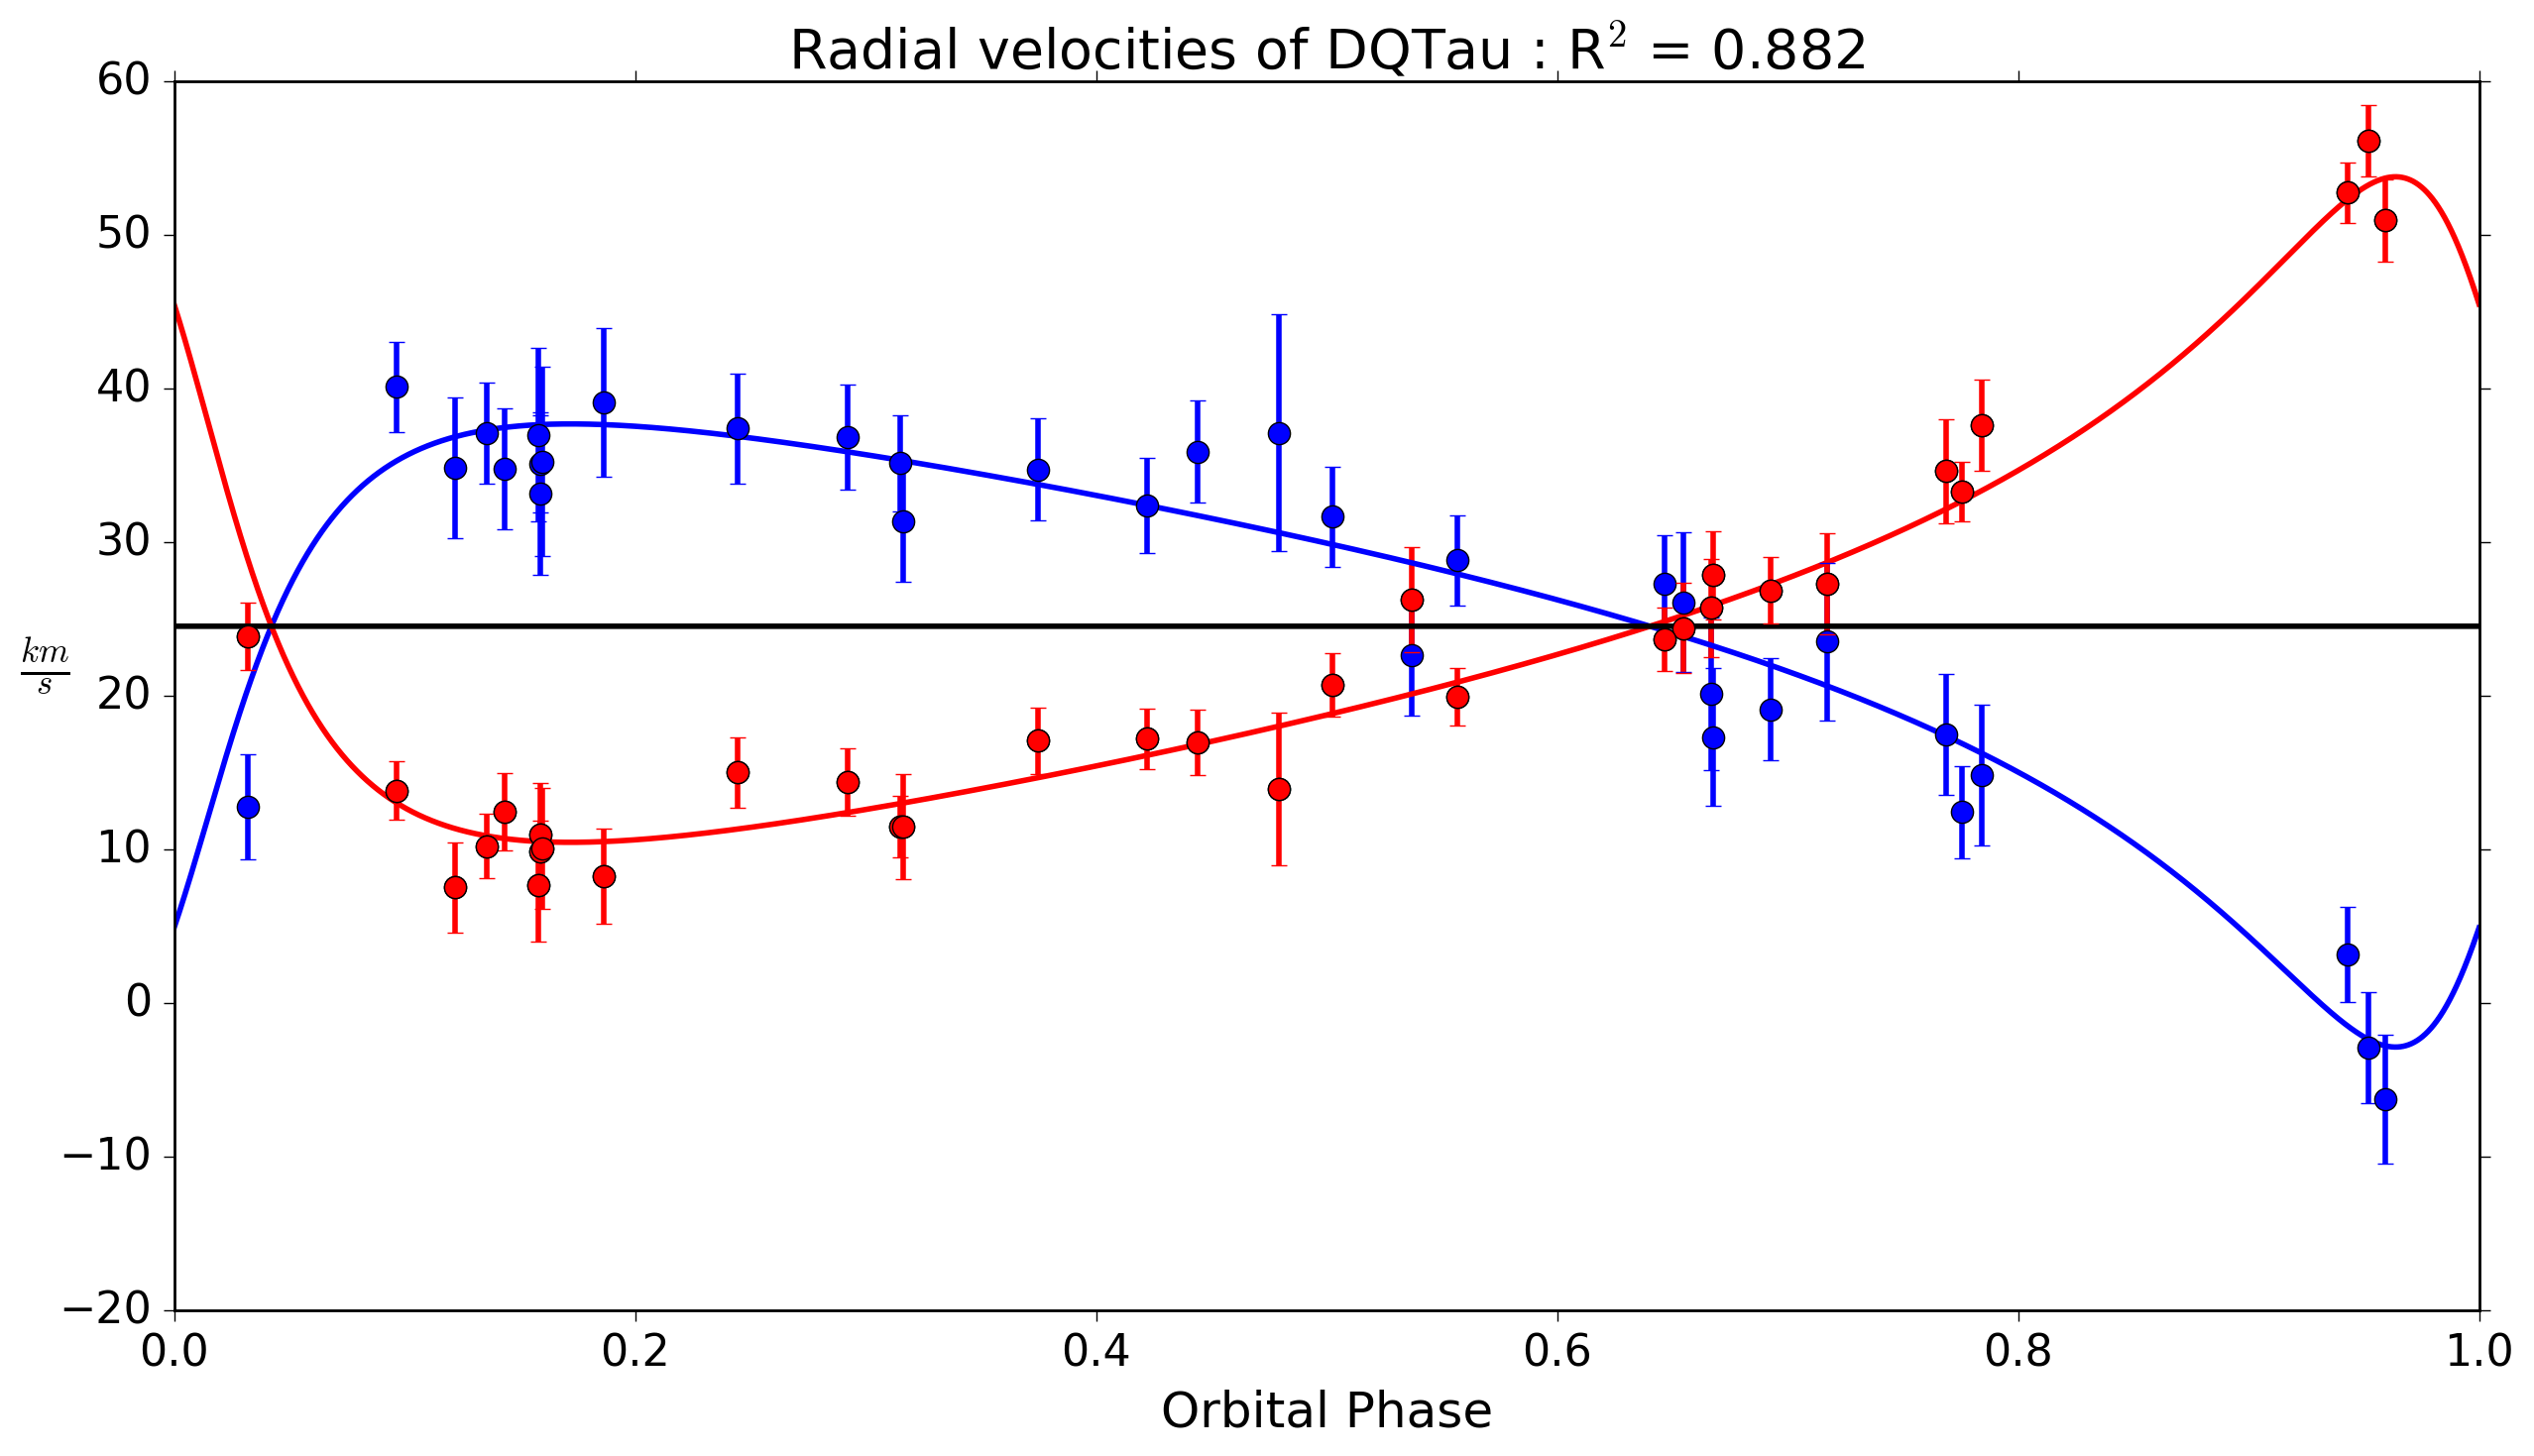

In [68]:
#These parameters are shared by the entire system, DQTau

P = 15.80158 #period in days determined first via periodogram
T = 47433.507 #Time offset in days, boils down to a horizontal shift in RV. T is the 'zero' point
e = 0.568 #eccentricity (unitless)
w = 4.047 #longitude of periastron in radians
y = 24.52 #systemic velocity in km/s
t = np.linspace(0, P, num = 10000)

#these parameters are star specific
K1= 20.28 #semamplitude in km/s
K2= -21.66

plt.figure(figsize=(15,8))
plt.plot(t/P, rv(K1, P, T, e, w, y, t))
plt.plot(t/P, rv(K2, P, T, e, w, y, t), 'r')
plt.plot(t/P, y*np.ones(t.size), 'k')
plt.errorbar(phases(T, HJD), DQTau1, yerr = oneError, fmt = 'bo')
plt.errorbar(phases(T, HJD), DQTau2, yerr = twoError, fmt = 'ro')
plt.plot(phases(T, HJD), DQTau2, 'ro')
#plt.plot(phases(T, HJD)*P, rv(K1, P, T, e, w, y, phases(T, HJD)*P), 'bo')
#plt.plot(phases(T, HJD)*P, rv(K2, P, T, e, w, y, phases(T, HJD)*P), 'mo')
plt.xlabel('Orbital Phase')
plt.ylabel('$\\frac{km}{s}$', rotation = 0)
plt.xlim(0,1)
plt.title('Radial velocities of DQTau : R$^2$ = 0.882')
plt.savefig('DQTauRVs.png')

In [69]:
def RSquared(data1, data2, fit1, fit2): #returns r squared when given an array of observed an expected values
    def average(data):
        return sum(data)/data.size
    R2 = 1-(sum((data1-fit1)**2)+sum((data2-fit2)**2))/(sum((data1-average(data1))**2)+sum(data2-average(data2))**2)
    return R2

#The calculation line has extra sum calls to prevent dimension mismatch errors between the RV data from a system

RSquared(DQTau1, DQTau2, rv(K1, P, T, e, w, y, phases(T, HJD)*P), rv(K2, P, T, e, w, y, phases(T, HJD)*P))

0.8819850296180517

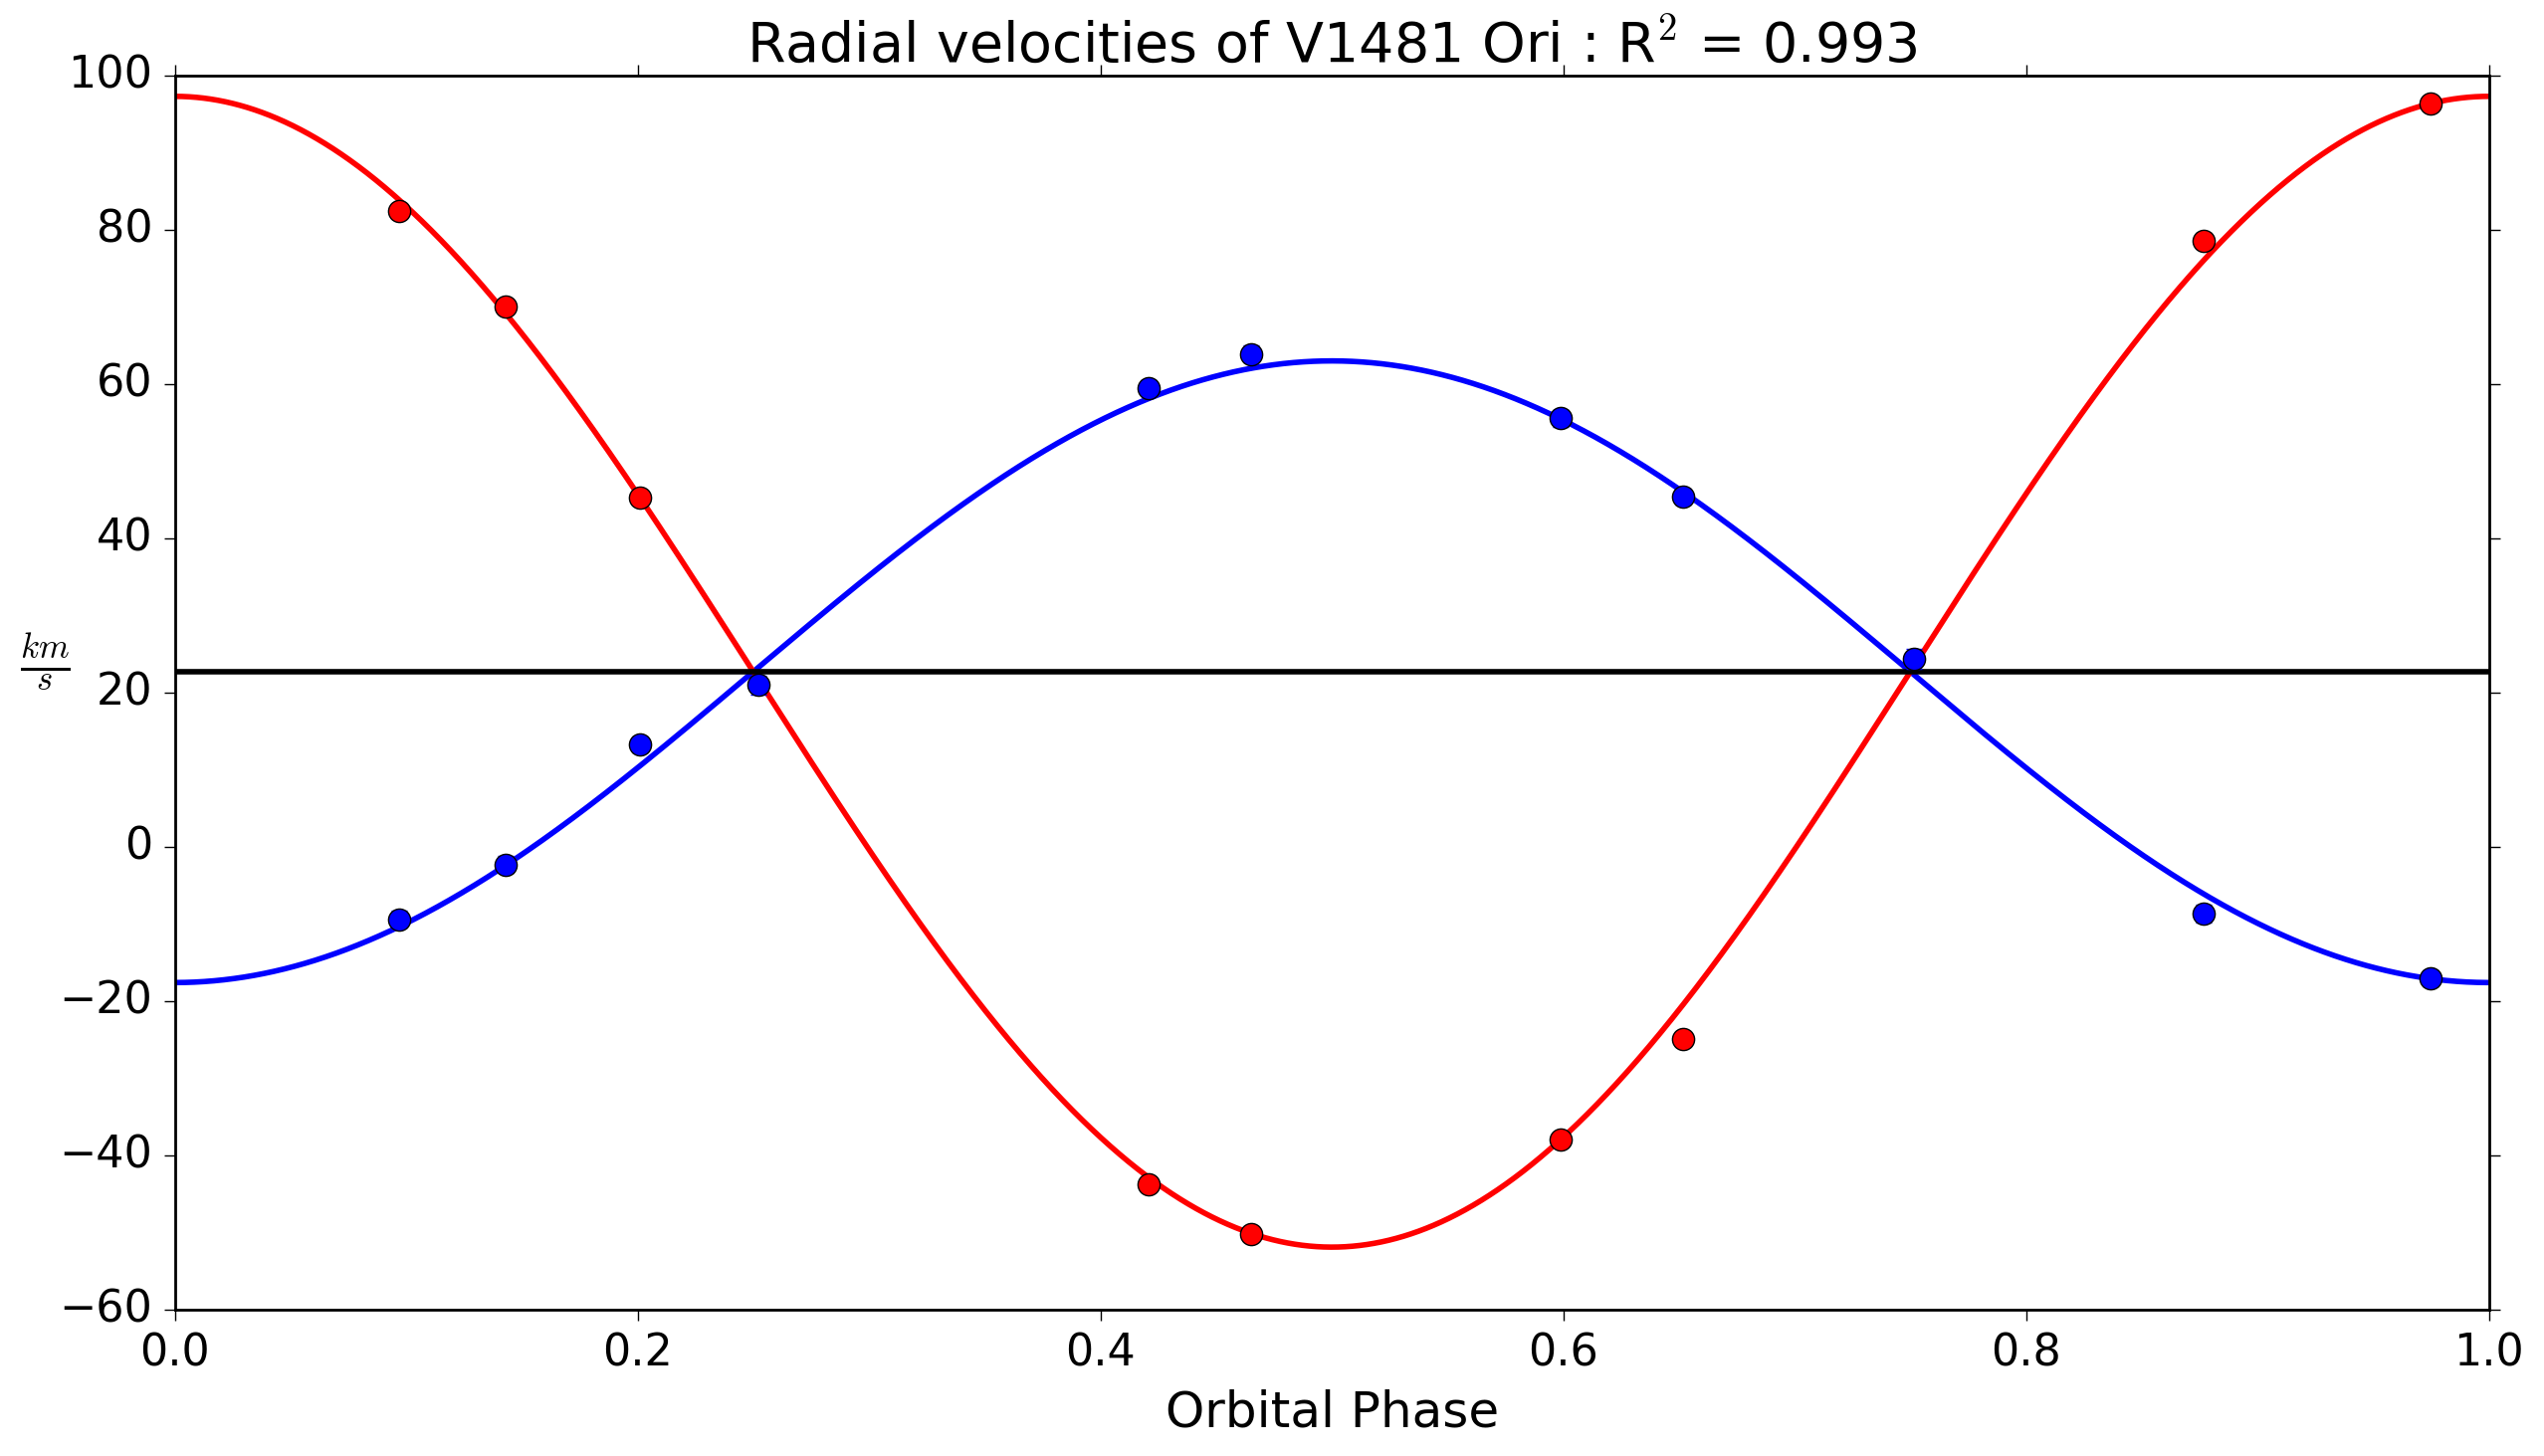

In [71]:
#Now for V1481 Ori

P = 4.433 #period in days determined first via periodogram
T = 3.3 #Time offset in days, boils down to a horizontal shift in RV. T is the 'zero' point
e = 0 #eccentricity (unitless)
w = 0 #longitude of periastron in radians
y = 22.7 #systemic velocity in km/s
t = np.linspace(0, P, num = 10000)

#these parameters are star specific
K1= -40.3 #semamplitude in km/s
K2= 74.6

plt.figure(figsize=(15,8))
plt.plot(t/P, rv(K1, P, T, e, w, y, t))
plt.plot(t/P, rv(K2, P, T, e, w, y, t), 'r')
plt.plot(t/P, y*np.ones(t.size), 'k')
plt.errorbar(phases(T, JD), V1481A, yerr = Aerror, fmt = 'bo')
plt.errorbar(phases(T, JDB), V1481B, yerr = Berror, fmt = 'ro')
#plt.plot(phases(T, JD), rv(K1, P, T, e, w, y, phases(T, JD)*P), 'bo')
#plt.plot(phases(T, JDB), rv(K2, P, T, e, w, y, phases(T, JDB)*P), 'mo')
plt.xlabel('Orbital Phase')
plt.ylabel('$\\frac{km}{s}$', rotation = 0)
plt.xlim(0,1)
plt.title('V1481 Ori')
plt.title('Radial velocities of V1481 Ori : R$^2$ = 0.993')
plt.savefig('V1481 Ori RVs.png')

In [48]:
RSquared(V1481A, V1481B, rv(K1, P, T, e, w, y, phases(JD)*P), rv(K2, P, T, e, w, y, phases(JDB)*P))

0.99315953151152958